### Updated Sample: 1440 Objects
- Chosen from the DR11 test brick region (ignoring the core of Coma). Galaxies span ~0.6-3 arcmin.
- Every galaxy name should be unique -- based on "central" coordinates of galaxy with a resolution of 3.6"

#### Columns:
- _INIT --> initial ellipse parameters (BX, BY are in pixels)
    - BA_INIT
    - PA_INIT
    - SMA_INIT
    - BX_INIT
    - BY_INIT
    - RA_INIT
    - DEC_INIT
- GROUP -->
    - GROUP_ID --> ID of group
    - GROUP_NAME --> name of group
    - GROUP_MULT --> number of objects in group
    - GROUP_PRIMARY --> object with the largest initial diameter
    - GROUP_RA --> RA of group center
    - GROUP_DEC --> DEC of group center
    - GROUP_DIAMETER --> Size of group (Mpc?)
- RA, DEC, BX, BY --> the 'final' values for the galaxy
- _MOMENT -->
    - SMA_MOMENT --> SMA of galaxy ellipse
    - BA_MOMENT --> BA (axis ratio) of galaxy ellipse
    - PA_MOMENT --> PA (position angle) of galaxy ellipse
- COG_MTOT_ --> total magnitude in [FUV NUV], [GRIZ], [W1-4]
- COG_MTOT_ERR_ --> errors for the above columns; now fixed.
- SMA50_ --> half-light SMA length in each bandpass based on the fit to the curve of growth
- FLUX_AP00, FLUX_P01, FLUX_AP02, FLUX_AP03, FLUX_AP04 --> flux measurements within each aperture (which is some multiple of SMA_MOMENT -- 0.5, 1.0, 1.25, 1.5, 2.0)

##### Note: there are 237 galaxies in the test catalog with more than one entry (SGAID), e.g. galaxy 1103727.

 ### Load modules and packages and libraries and tables and...

In [1]:
import numpy as np
from rich import print
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table
import pandas as pd
import seaborn as sns

import os
homedir=os.getenv("HOME")

In [2]:
#read in the .fits file. first is ellipse fitting, second is SExtractor.
ellipse_tab=Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/SGA2025-ellipse-v0.2.fits',hdu=1)
tractor_tab=Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/SGA2025-ellipse-v0.2.fits',hdu=2)

### QA One
#### Separations between RADEC_INIT, RADEC_FINAL, and RADEC_TRACTOR

In [3]:
#ellipse_tab.columns --> RA_INIT, DEC_INIT, RA, DEC, RA_TRACTOR, DEC_TRACTOR

In [60]:
radec_init = ellipse_tab['RA_INIT'], ellipse_tab['DEC_INIT']
radec_final = ellipse_tab['RA'], ellipse_tab['DEC']
radec_tractor = ellipse_tab['RA_TRACTOR'], ellipse_tab['DEC_TRACTOR']

zero_flag = (radec_tractor[0]!=0) & (radec_tractor[1]!=0)

separations = []

separations.append((radec_init[0][flag]-radec_final[0][flag])*np.cos(np.deg2rad(radec_final[1][flag])))
separations.append(radec_init[1][flag]-radec_final[1][flag])
separations.append((radec_init[0][flag]-radec_tractor[0][flag])* np.cos(np.deg2rad(radec_tractor[1][flag])))
separations.append(radec_init[1][flag]-radec_tractor[1][flag])
separations.append((radec_tractor[0][flag]-radec_final[0][flag])* np.cos(np.deg2rad(radec_final[1][flag])))
separations.append(radec_tractor[1][flag]-radec_final[1][flag])

separations = np.asarray(separations)

In [61]:
import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame({'RA_INIT - RA_FINAL': separations[0],
                'DEC_INIT - DEC_FINAL': separations[1],
                'RA_INIT - RA_TRACTOR': separations[2],
                'DEC_INIT - DEC_TRACTOR': separations[3],
                'RA_TRACTOR - RA_FINAL': separations[4],
                'DEC_TRACTOR - DEC_FINAL': separations[5]})

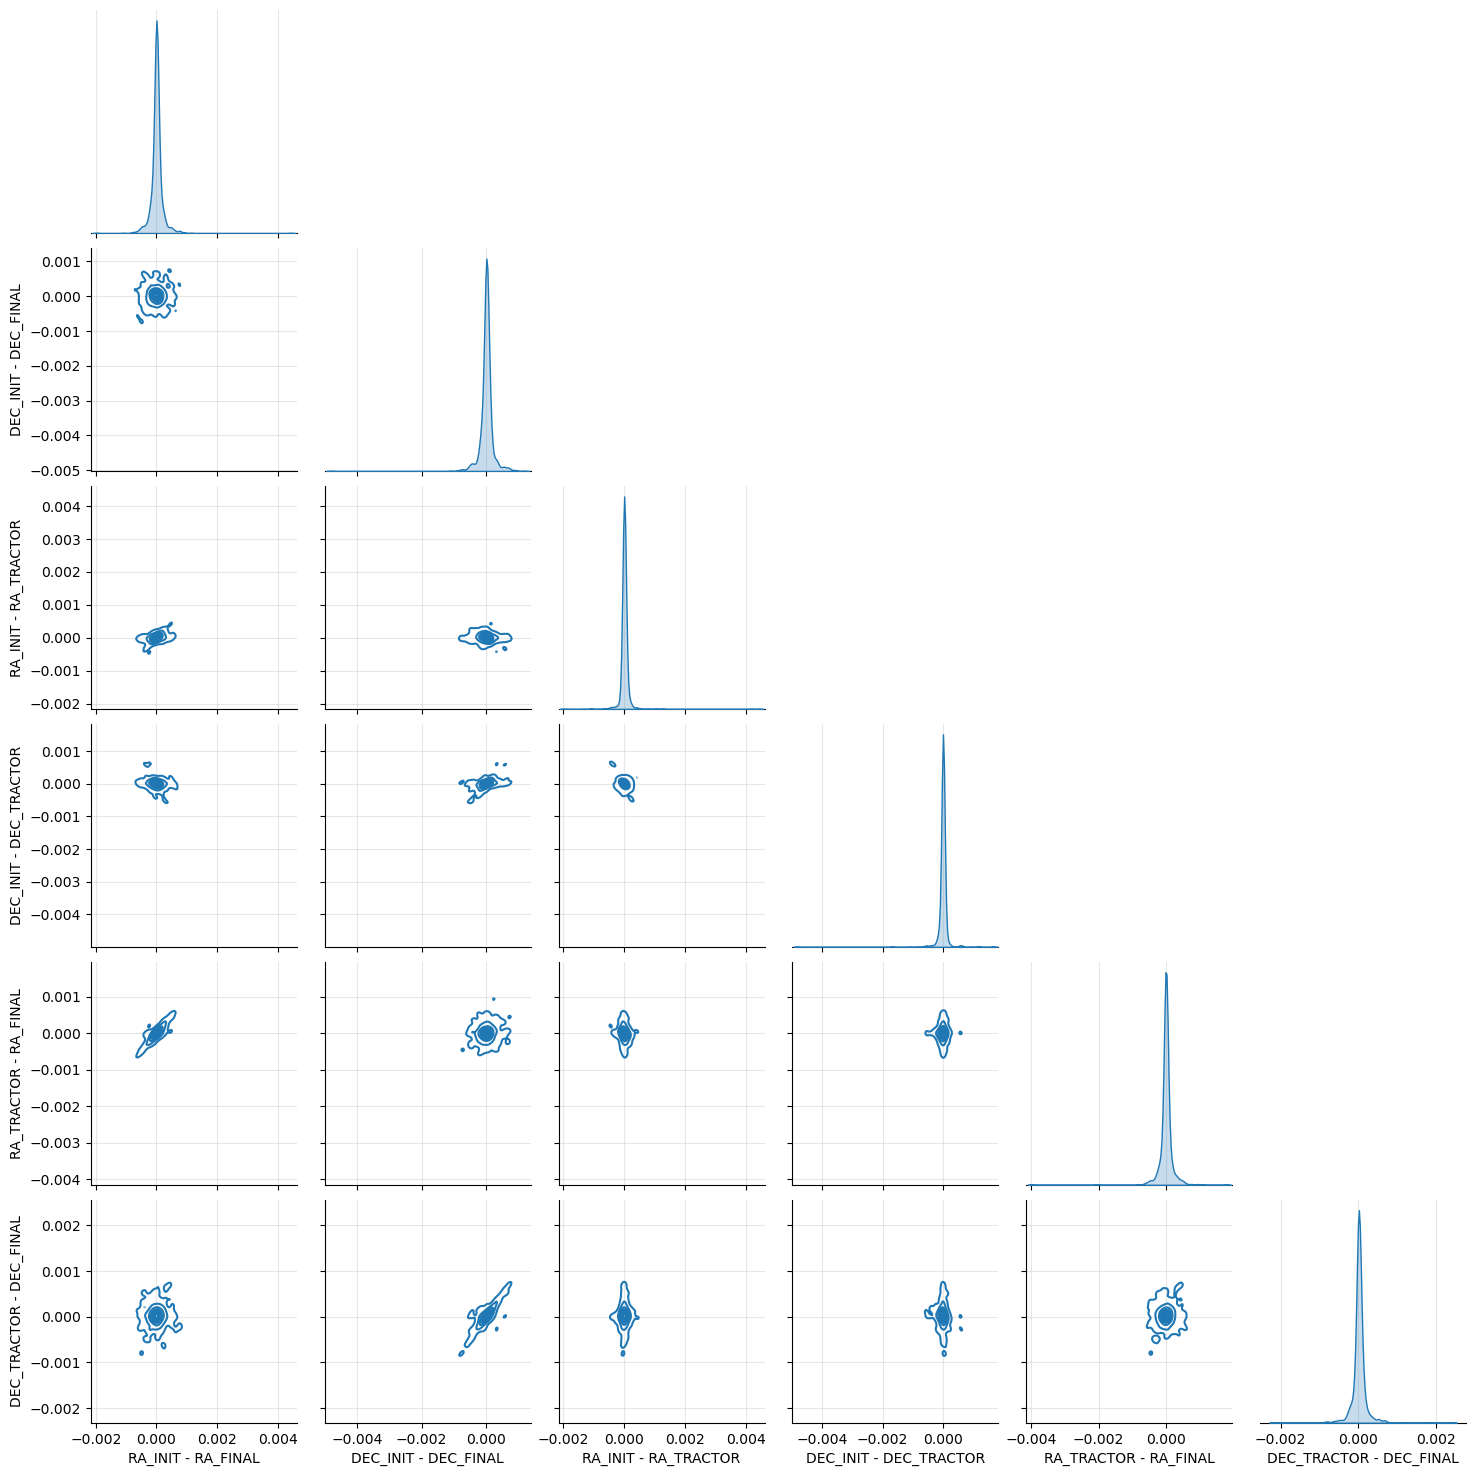

In [62]:
p = sns.pairplot(df, corner=True, kind="kde", plot_kws={'levels':10})

for ax in p.axes.flat:
    if ax is not None:
        #ax.axvline(0, color='red',ls='--',alpha=0.3)
        #ax.axhline(0, color='red',ls='--',alpha=0.3)
        ax.grid(alpha=0.3)
plt.show()

In [63]:
for column in df.columns:
    sep_flag=(df[column]>0.001)
    if np.sum(flag)>0:
        sganame = ellipse_tab['SGAID'][zero_flag]
        sganame=sganame[sep_flag]
        print(f'Galaxy with separation > 3.6" for {column}: {sganame[0]}')
        print(f'Separation: {df[column][sep_flag].values[0]*3600:.3f}"')
        print()

Galaxy with separation > 3.6" for RA_INIT - RA_FINAL: 1101899

Separation: 15.908"

Galaxy with separation > 3.6" for DEC_INIT - DEC_FINAL: 1100305

Separation: 4.281"

Galaxy with separation > 3.6" for RA_INIT - RA_TRACTOR: 2107236

Separation: 4.592"

Galaxy with separation > 3.6" for DEC_INIT - DEC_TRACTOR: 2107236

Separation: 5.993"

Galaxy with separation > 3.6" for RA_TRACTOR - RA_FINAL: 4965698

Separation: 3.927"

Galaxy with separation > 3.6" for DEC_TRACTOR - DEC_FINAL: 5056650

Separation: 4.033"

### QA Two
#### Separations between BAPA_INIT and BAPA_FINAL

In [108]:
bapa_init = ellipse_tab['BA_INIT'], ellipse_tab['PA_INIT']
bapa_final = ellipse_tab['BA'], ellipse_tab['PA']

ba_flag = (bapa_init[0]!=1)  #some default to one (circle) as an initial BA guess

diff_ba = bapa_init[0][ba_flag]-bapa_final[0][ba_flag]
diff_pa = bapa_init[1][ba_flag]-bapa_final[1][ba_flag]

relative_diff_ba = diff_ba/bapa_init[0][ba_flag]
relative_diff_pa = diff_pa/bapa_init[1][ba_flag]

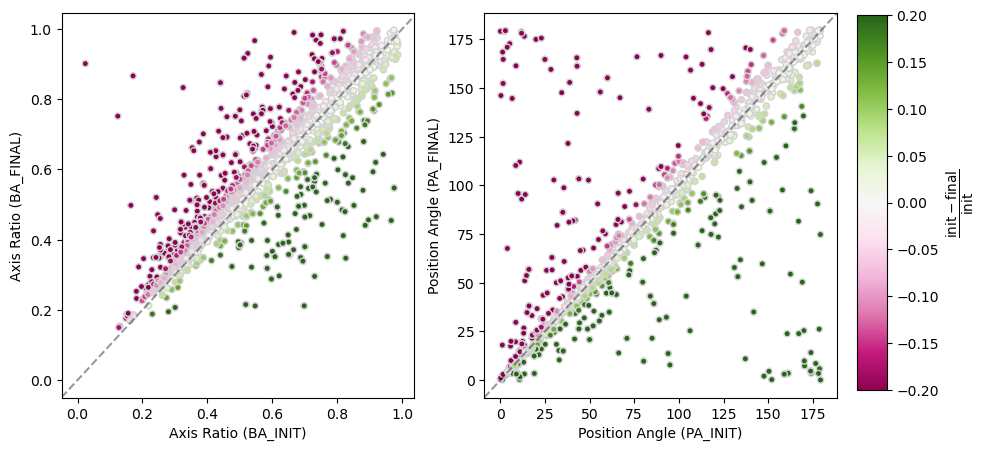

In [109]:
#plot for diagnostic purposes. which SG coordinate best correlates with redshift?
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].scatter(bapa_init[0][ba_flag], bapa_final[0][ba_flag], s=20, c=relative_diff_ba,
                    cmap='PiYG', vmin=-0.2, vmax=0.2, edgecolor='lightgray')
axs[0].axline([0,0],slope=1,color='black',ls='--',alpha=0.4)
axs[0].set_xlabel('Axis Ratio (BA_INIT)')
axs[0].set_ylabel('Axis Ratio (BA_FINAL)')

im2 = axs[1].scatter(bapa_init[1][ba_flag], bapa_final[1][ba_flag], s=20, c=relative_diff_pa,
                    cmap='PiYG', vmin=-0.2, vmax=0.2, edgecolor='lightgray')
axs[1].axline([0,0],slope=1,color='black',ls='--',alpha=0.4)
axs[1].set_xlabel('Position Angle (PA_INIT)')
axs[1].set_ylabel('Position Angle (PA_FINAL)')

#relative x coord, relative y coord, relative thickness/width, relative length
cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.75]) 
cbar=fig.colorbar(im2, cax=cbar_ax)

#cbar = fig.colorbar(im2, ax=axs[1])
cbar.set_label(r'$\frac{\text{init}-\text{final}}{\text{init}}$',fontsize=14)

In [112]:
for i in range(len(bapa_init[0][ba_flag])):
    if (np.abs(relative_diff_ba[i])>0.6):
        sganame = ellipse_tab['SGAID'][ba_flag][i]
        print(f'Galaxy with relative separation > 60% for BA: {sganame}') 
        print(f'Separation (BA): {diff_ba[i]:.3f}')
        print()

Galaxy with relative separation > 60% for BA: 4740563

Separation (BA): -0.224

Galaxy with relative separation > 60% for BA: 1261410

Separation (BA): 0.487

Galaxy with relative separation > 60% for BA: 4698702

Separation (BA): -0.143

Galaxy with relative separation > 60% for BA: 4789330

Separation (BA): -0.134

Galaxy with relative separation > 60% for BA: 8579

Separation (BA): -0.303

Galaxy with relative separation > 60% for BA: 1261374

Separation (BA): -0.205

Galaxy with relative separation > 60% for BA: 4267167

Separation (BA): -0.407

Galaxy with relative separation > 60% for BA: 4967960

Separation (BA): -0.332

Galaxy with relative separation > 60% for BA: 4514227

Separation (BA): -0.695

Galaxy with relative separation > 60% for BA: 4994104

Separation (BA): -0.421

Galaxy with relative separation > 60% for BA: 1308545

Separation (BA): -0.877

Galaxy with relative separation > 60% for BA: 4506850

Separation (BA): -0.628

Galaxy with relative separation > 60% for BA: 4755994

Separation (BA): -0.256

Galaxy with relative separation > 60% for BA: 5074883

Separation (BA): -0.406

Galaxy with relative separation > 60% for BA: 3183941

Separation (BA): -0.186

Galaxy with relative separation > 60% for BA: 5085419

Separation (BA): -0.333

Galaxy with relative separation > 60% for BA: 1261476

Separation (BA): -0.309

Galaxy with relative separation > 60% for BA: 5065845

Separation (BA): -0.314

Galaxy with relative separation > 60% for BA: 1261476

Separation (BA): -0.309

Galaxy with relative separation > 60% for BA: 4267167

Separation (BA): -0.407

Galaxy with relative separation > 60% for BA: 1101495

Separation (BA): -0.508

Galaxy with relative separation > 60% for BA: 488256

Separation (BA): -0.404

Galaxy with relative separation > 60% for BA: 488256

Separation (BA): -0.404

Galaxy with relative separation > 60% for BA: 1261410

Separation (BA): 0.487

Galaxy with relative separation > 60% for BA: 1261374

Separation (BA): -0.205

Galaxy with relative separation > 60% for BA: 1107791

Separation (BA): -0.274

Galaxy with relative separation > 60% for BA: 3184220

Separation (BA): -0.290

Galaxy with relative separation > 60% for BA: 1310732

Separation (BA): -0.295

Galaxy with relative separation > 60% for BA: 1311383

Separation (BA): -0.191

Galaxy with relative separation > 60% for BA: 1311383

Separation (BA): -0.191

Galaxy with relative separation > 60% for BA: 3207321

Separation (BA): 0.336

Galaxy with relative separation > 60% for BA: 4267167

Separation (BA): -0.407

Galaxy with relative separation > 60% for BA: 1311493

Separation (BA): -0.278

Galaxy with relative separation > 60% for BA: 1311493

Separation (BA): -0.278

### QA Three
#### SMA_INIT vs. SMA_MOMENT

In [152]:
#diam_init = ellipse_tab['DIAM_INIT'] #arcminutes

sma_init = ellipse_tab['SMA_INIT']    #arcseconds
sma_final = ellipse_tab['SMA_MOMENT'] #arcseconds

diff_sma = sma_init-sma_final

relative_diff_sma = diff_sma/sma_init

In [153]:
#finding the median ratio (slope):
scale_median = np.median(sma_final / sma_init)
print(f"Median SMA scale factor: {scale_median:.3f}")

Median SMA scale factor: 0.706

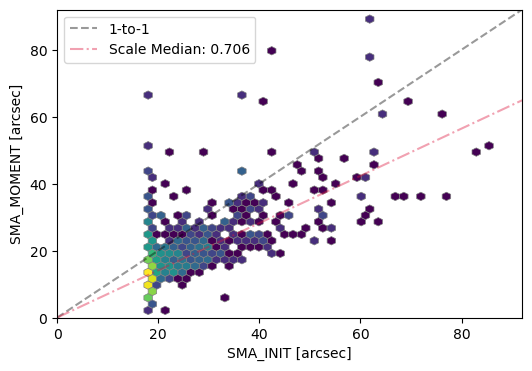

In [154]:
plt.figure(figsize=(6,4))

#mincnt=1 means ignore empty bins
hb = plt.hexbin(sma_init, sma_final, gridsize=40, cmap='viridis', mincnt=1, linewidths=0.5, edgecolors='gray',
               bins='log')

#plt.scatter(sma_init[~ba_flag], sma_final[~ba_flag], color='red', s=5)

plt.xlabel('SMA_INIT [arcsec]')
plt.ylabel('SMA_MOMENT [arcsec]')
plt.axline([0,0],slope=1,color='black',ls='--',alpha=0.4, label='1-to-1')
plt.axline([0,0], slope=scale_median, color='crimson', ls='-.',alpha=0.4,label=f'Scale Median: {scale_median:.3f}')
plt.xlim(0,92)
plt.ylim(0,92)
plt.legend()
plt.show()

In [167]:
print(f'[red] N Galaxies with relative separation > 50%: {len(ellipse_tab[np.abs(relative_diff_sma)>0.5])}')

for i in range(len(sma_init)):
    if (np.abs(relative_diff_sma[i])>0.9):
        sganame = ellipse_tab['SGAID'][i]
        print(f'Galaxy with relative separation > 90% for SMA: {sganame}')
        print(f'Separation: {diff_sma[i]:.3f}')
        print()

 N Galaxies with relative separation > 50%: 233

Galaxy with relative separation > 90% for SMA: 4894769

Separation: -38.131

Galaxy with relative separation > 90% for SMA: 1100308

Separation: -23.738

Galaxy with relative separation > 90% for SMA: 4514227

Separation: 19.671

Galaxy with relative separation > 90% for SMA: 4994104

Separation: -26.853

Galaxy with relative separation > 90% for SMA: 5074651

Separation: -26.964

Galaxy with relative separation > 90% for SMA: 5093796

Separation: -49.608

Galaxy with relative separation > 90% for SMA: 1101899

Separation: -17.638

Galaxy with relative separation > 90% for SMA: 5093796

Separation: -49.608

Galaxy with relative separation > 90% for SMA: 3925862

Separation: -16.979

Galaxy with relative separation > 90% for SMA: 1100308

Separation: -23.738

Galaxy with relative separation > 90% for SMA: 3212772

Separation: -18.851

Galaxy with relative separation > 90% for SMA: 477932

Separation: -20.531

Galaxy with relative separation > 90% for SMA: 3184228

Separation: -17.728

Galaxy with relative separation > 90% for SMA: 4613728

Separation: -16.604

Galaxy with relative separation > 90% for SMA: 3184080

Separation: -32.956

Galaxy with relative separation > 90% for SMA: 3184080

Separation: -32.956

Galaxy with relative separation > 90% for SMA: 792784

Separation: -25.051

Galaxy with relative separation > 90% for SMA: 792784

Separation: -25.051

### QA Four
#### MTOT_ERR vs. MTOT in each wavelength band
#### [COG_MTOT_G - COG_MTOT_R] vs. [COG_MTOT_R - COG_MTOT_Z]
- 10 bands --> FUV, NUV, griz, W1-4
- Notes:
    - band label inconsistency:
        - MTOT_COG_[GRIZ]
        - MTOT_COG_ERR_[GRIZ]
    - ~~All COG_MTOT_ERR_* rows are 0~~    **Fixed!**

In [187]:
bands=['FUV','NUV','G','R','I','Z','W1','W2','W3','W4']   #uppercase GRIZ for MTOT

mtots = [f'COG_MTOT_{band}' for band in bands]
mtot_errs = [f'COG_MTOT_ERR_{band}' for band in bands]

chi_2s = [f'COG_CHI2_{band}' for band in bands]
n_dofs = [f'COG_NDOF_{band}' for band in bands]

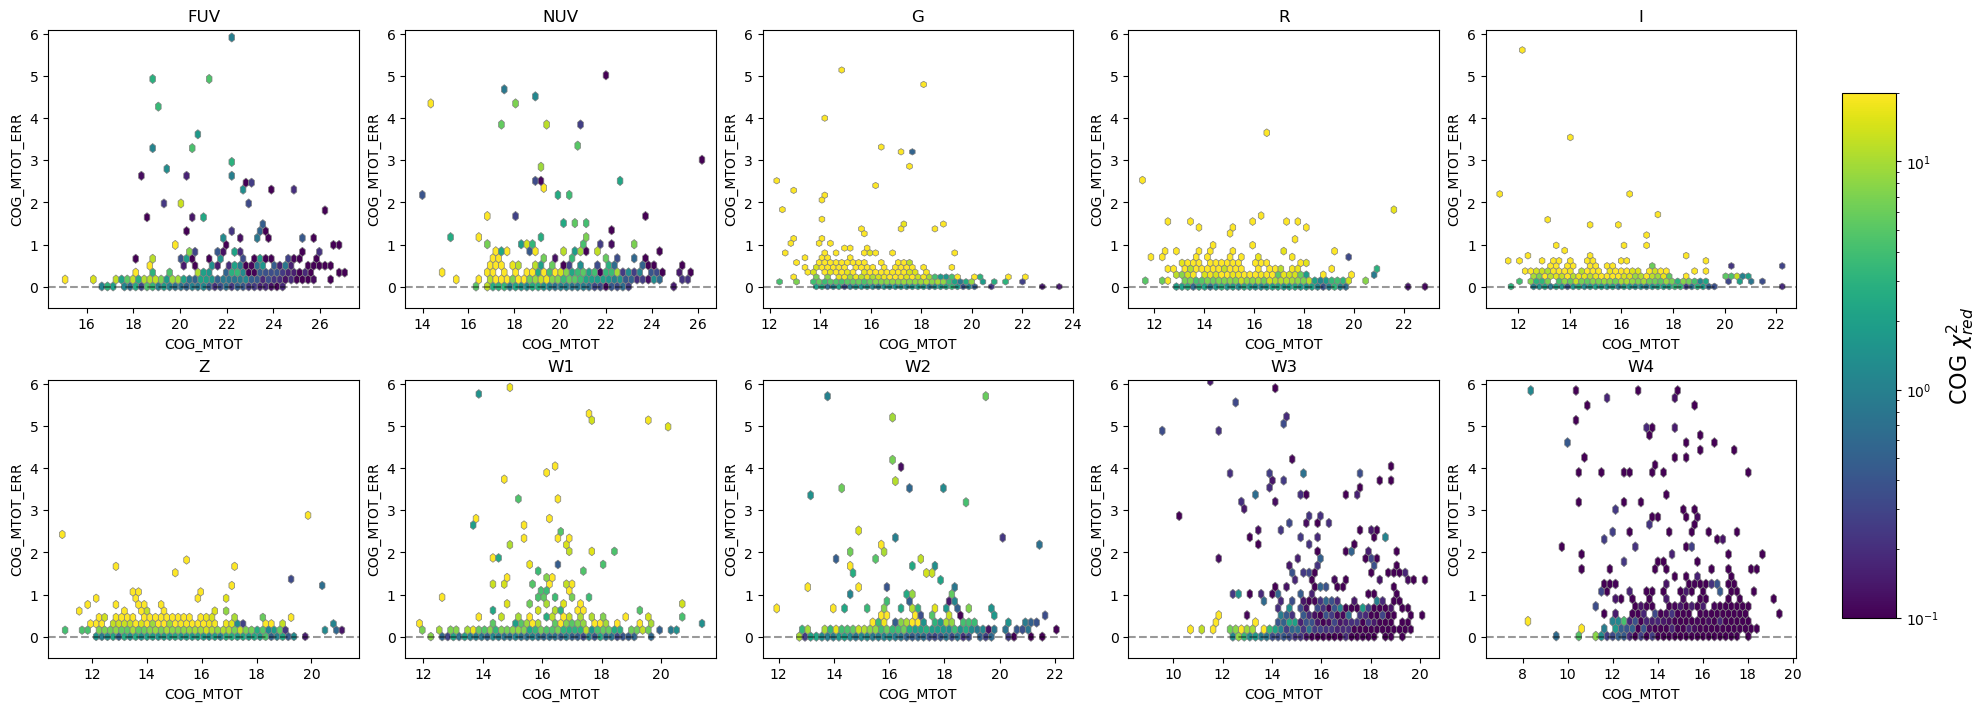

In [217]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
       
    #reduced chi-squared
    red_chi2 = ellipse_tab[chi_2s[i-1]] / ellipse_tab[n_dofs[i-1]]

    ax.set_title(bands[i-1])
    ax.set_xlabel("COG_MTOT")
    ax.set_ylabel("COG_MTOT_ERR")
    
    err_flag=(ellipse_tab[mtot_errs[i-1]]<10) & (ellipse_tab[mtots[i-1]]!=0)
    
    im1 = ax.hexbin(
        ellipse_tab[err_flag][mtots[i-1]], 
        ellipse_tab[err_flag][mtot_errs[i-1]],
        C=red_chi2[err_flag], gridsize=50, mincnt=1, linewidths=0.5, edgecolors='gray', 
        reduce_C_function=np.median,
        bins='log', vmin=0.1, vmax=20)

    ax.axhline(0,color='black',ls='--',alpha=0.4)
    ax.set_ylim(-0.5,6.1)
    
cbar_ax = fig.add_axes([1.02, 0.125, 0.03, 0.75]) 
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label(r'COG $\chi^2_{red}$', fontsize=16)

plt.show()

In [218]:
for band in bands:
    large_err_flag = (ellipse_tab[f'COG_MTOT_ERR_{band}']>10)
    
    if np.sum(large_err_flag)>0:
        sganame = ellipse_tab['SGAID'][large_err_flag]

        print(f'Galaxies with >10 {band} MTOT ERR: {len(sganame)}') 
        print(f'{sganame.data}')
        print()

Galaxies with >10 FUV MTOT ERR: 53

[4752852 3151782 4867896 3151782 4750023 4749737 4888303 4849257 4935021
 5041201 4990307 4720039 4821830 4759013 4893915 4967038 4729647 4799452
 4935021 4941387 4888303 3213372 1101899 3164933 4752852 4799348 3212901
 3183881 3164899 1309497 3213689 3183712 3183712  903069  903069 1103108
 3213372 4505492 3183798 3183857 3183857 3214533 3214533 1104111 1104111
 4849257 3183619 3183619 1309497 1309497 3184244 3184244 3184244]

Galaxies with >10 NUV MTOT ERR: 23

[4921296 4752852 4994104 5040488 3164918 4851297 1311543 3164918 3183574
 4752852 5065845 3164918 5056653 3184411 1311543 3177208  903069  903069
 2405141 3164918 1309439 1309439 1311543]

Galaxies with >10 G MTOT ERR: 9

[1274237 5056706 1103108 1274237 3212772 1301336 1309414 3184080 3184080]

Galaxies with >10 R MTOT ERR: 3

[5056706 1301336 1309414]

Galaxies with >10 I MTOT ERR: 10

[4794062 1311453 5017396 4942173 5056706 1301336 1309417 1311453 1261520
 1261520]

Galaxies with >10 Z MTOT ERR: 9

[5056706 1103108 3212772  477932 1301336 1309414 3184128 3184136 4613728]

Galaxies with >10 W1 MTOT ERR: 25

[1100308 5056650 5056692 5056712 3184395 5056649 3940147 5056706 5056704
 5056622 3184319 1296262 1100308 1103108 3940147 1107791 3184262 3184262
 1301336 2405116 5056692 5056691 5056692 3128916 5056704]

Galaxies with >10 W2 MTOT ERR: 18

[1100308 1102688 3184395 5056649 5056653 5056706 3184319 1102688 1296262
 1100308 1100305 1099563 1107791 1301336 2405116 5056691 1309669 1309669]

Galaxies with >10 W3 MTOT ERR: 47

[4801193 4771046 4762579 4735990 4948573 4813795 4918955 5056650 1102688
 4940148 4811376 4942464 4821243 4724585 4896229 4720039 4873369 5056720
 4504657 3183926 4862659 1100914 4775622 2409831 4708403 4796663 5097619
 1105186 4504657 1100914 3213203 3213719 1102688 3213341 3183937 5056688
 1100914 1100914 1103049 1103049 3183798 1108761 3214348 3214348 4940148
 3807615 2405119]

Galaxies with >10 W4 MTOT ERR: 93

[4678401 5030860 4851596 4913489 4991110 4894061 4961000 1261410 4728214
 4851209 4763928 4793284 4916088 4749267 4986205 4986271 4722740 4963927
 4677392 4703336 5011564 4983764 4749737 4918010 4991394 4824683 4889038
 4774681 4724585 4951679 4817177 4824974 4913489 4889038 4992311 4976174
 4961568 4700719 3183493 4755994 4875318 5033044 4676275 4886297 3213288
 4889537 4981194 5060647 5081032 3164952 5030922 4708403 5011519 4826309
 3208198 3183768 3164901 1105186 3213680 3212717 3213628 3184500 5056699
 3165124 3407278 1101495 3183712 3183712 4700719 1261410 3412902 3412902
 5056686 3183825 3183825 1099117 1099117 3344627 3214385 3214385 3214385
 3184220 1771965 1104307 1309414 3183493 3183493 3184136 3220689 3220689
 3208183 3208183 5056698]

#### g-r vs. r-z plot:

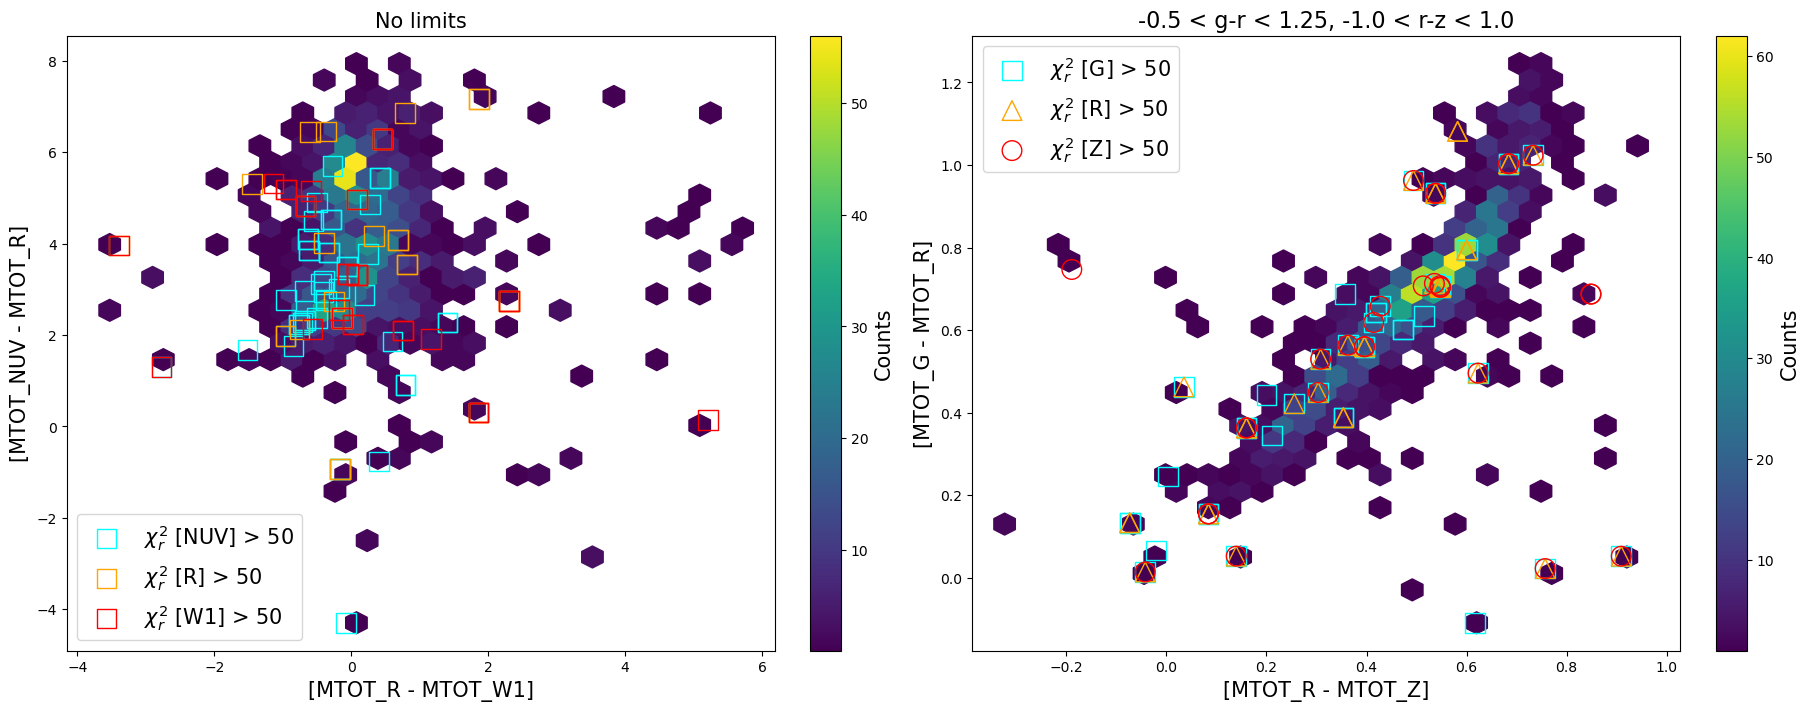

In [340]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), constrained_layout=True)
ax1, ax2 = axes.ravel()

chi2_lim = 50

##############################
#left panel, NUV-r vs. r-W1
##############################

#removing cases with MTOT == 0, just in case
err_flag = (ellipse_tab['COG_MTOT_W1']!=0) & \
(ellipse_tab['COG_MTOT_R']!=0) & \
(ellipse_tab['COG_MTOT_NUV']!=0)

#defining some reduced chi^2 limit for the relevant bands' COGs
red_chi2_nuv = ((ellipse_tab['COG_CHI2_NUV']/ellipse_tab['COG_NDOF_NUV']) > chi2_lim) & err_flag 
red_chi2_r = ((ellipse_tab['COG_CHI2_R']/ellipse_tab['COG_NDOF_R']) > chi2_lim) & err_flag 
red_chi2_w1 = ((ellipse_tab['COG_CHI2_W1']/ellipse_tab['COG_NDOF_W1']) > chi2_lim) & err_flag 

nuv_r = ellipse_tab['COG_MTOT_NUV'] - ellipse_tab['COG_MTOT_R'] 
r_w1 = ellipse_tab['COG_MTOT_R'] - ellipse_tab['COG_MTOT_W1']

#hexbin density map...
im1 = ax1.hexbin(r_w1[err_flag], nuv_r[err_flag], gridsize=30, cmap='viridis', mincnt=1)
cb1 = fig.colorbar(im1, ax=ax1)
cb1.set_label('Counts', fontsize=15)

ax1.scatter(r_w1[red_chi2_nuv], nuv_r[red_chi2_nuv], marker='s',
            edgecolor='cyan', facecolor='none', s=200, label=fr'$\chi^2_r$ [NUV] > {chi2_lim}')
ax1.scatter(r_w1[red_chi2_r], nuv_r[red_chi2_r], marker='s',
            edgecolor='orange', facecolor='none', s=200, label=fr'$\chi^2_r$ [R] > {chi2_lim}')
ax1.scatter(r_w1[red_chi2_w1], nuv_r[red_chi2_w1], marker='s',
            edgecolor='red', facecolor='none', s=200, label=fr'$\chi^2_r$ [W1] > {chi2_lim}')

#labels and such
ax1.set_xlabel("[MTOT_R - MTOT_W1]",fontsize=15)
ax1.set_ylabel("[MTOT_NUV - MTOT_R]",fontsize=15)

ax1.legend(fontsize=15, loc='lower left')
ax1.set_title('No limits', fontsize=15)

##############################
##############################
##############################

#removing cases with MTOT == 0, just in case
err_flag = (ellipse_tab['COG_MTOT_G']!=0) & \
(ellipse_tab['COG_MTOT_R']!=0) & \
(ellipse_tab['COG_MTOT_Z']!=0)

#defining the colors
g_r = ellipse_tab['COG_MTOT_G'] - ellipse_tab['COG_MTOT_R'] 
r_z = ellipse_tab['COG_MTOT_R'] - ellipse_tab['COG_MTOT_Z']

#color flag (to remove significant outliers)
color_flag = (g_r > -0.5) & (g_r < 1.25) & (r_z > -1.) & (r_z < 1.)

#defining some reduced chi^2 limit for the optical bands' COGs
red_chi2_g = ((ellipse_tab['COG_CHI2_G']/ellipse_tab['COG_NDOF_G']) > chi2_lim) & err_flag & color_flag
red_chi2_r = ((ellipse_tab['COG_CHI2_R']/ellipse_tab['COG_NDOF_R']) > chi2_lim) & err_flag & color_flag
red_chi2_z = ((ellipse_tab['COG_CHI2_Z']/ellipse_tab['COG_NDOF_Z']) > chi2_lim) & err_flag & color_flag

#right panel, the 'clips'
#hexbin density map...
im2 = ax2.hexbin(r_z[color_flag & err_flag], g_r[color_flag & err_flag], gridsize=30, cmap='viridis', mincnt=1)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('Counts', fontsize=15)

#flagged points with high-ish reduced chi^2
ax2.scatter(r_z[red_chi2_g], g_r[red_chi2_g], marker='s',
            edgecolor='cyan', facecolor='none', s=200, label=fr'$\chi^2_r$ [G] > {chi2_lim}')

ax2.scatter(r_z[red_chi2_r], g_r[red_chi2_r], marker='^',
            edgecolor='orange', facecolor='none', s=200, label=fr'$\chi^2_r$ [R] > {chi2_lim}')

ax2.scatter(r_z[red_chi2_z], g_r[red_chi2_z], marker='o',
            edgecolor='red', facecolor='none', s=200, label=fr'$\chi^2_r$ [Z] > {chi2_lim}')

#labels and such
ax2.set_xlabel("[MTOT_R - MTOT_Z]",fontsize=15)
ax2.set_ylabel("[MTOT_G - MTOT_R]",fontsize=15)

ax2.legend(loc='upper left',fontsize=15)
ax2.set_title('-0.5 < g-r < 1.25, -1.0 < r-z < 1.0', fontsize=16)

plt.show()

### QA Five
#### SMA50_ vs. SMA_MOMENT
 - This diagnostic will give us an idea of how these properties correlate
   - i.e., can SMA_MOMENT/2 be a reasonable proxy for the half-light radius?
 - Note that I specifically plot 2 * SMA50_ vs. SMA_MOMENT
 

In [350]:
bands=['NUV','G','R','I','Z','W1']   #uppercase GRIZ for SMA50

sma50 = [f'SMA50_{band}' for band in bands]

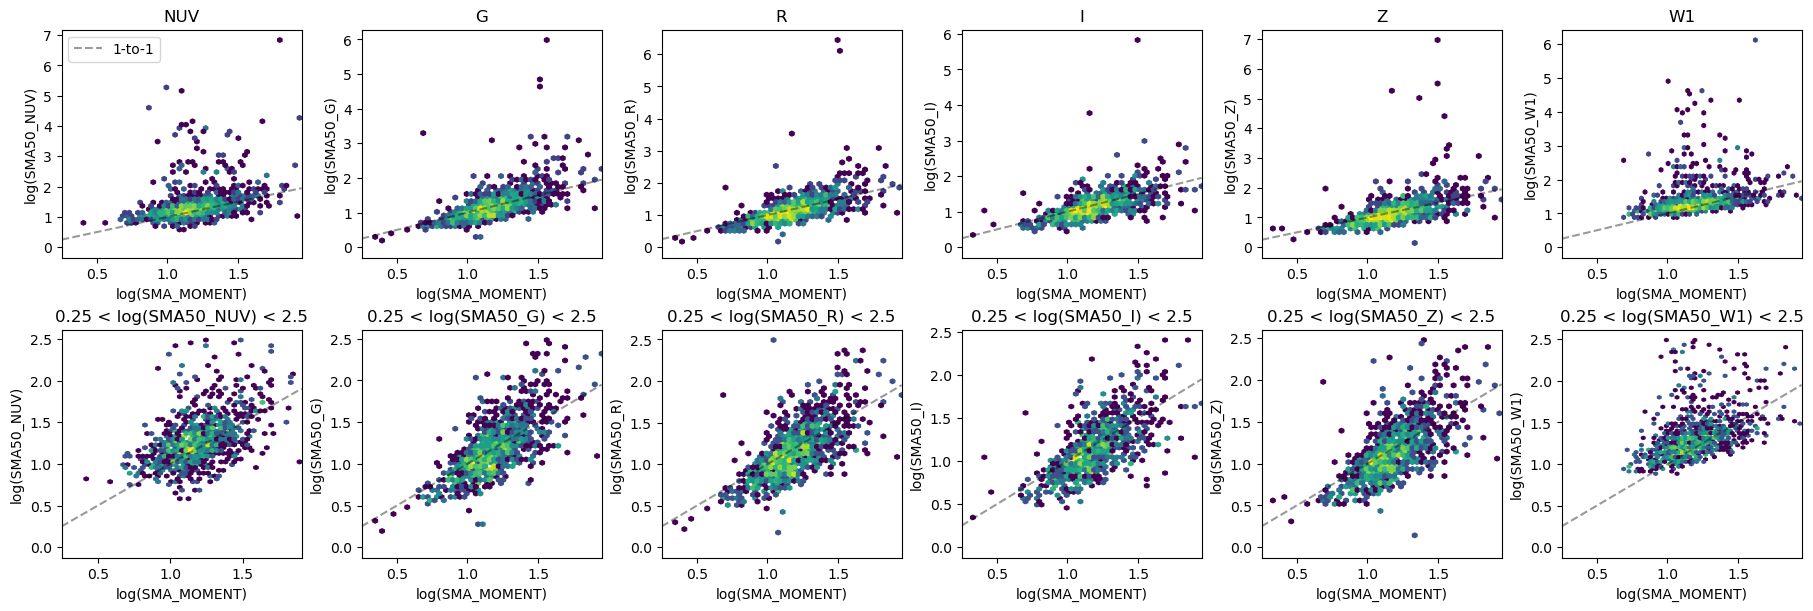

In [383]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    
    if i<7:
        index = i-1
        ylim = 0, 0
        title = bands[index]
        
        flag=np.ones(len(ellipse_tab), dtype=bool)
        
    else:
        index = i-7
        ylim = 0.25, 2.5
        title = f'{ylim[0]} < log(SMA50_{bands[index]}) < {ylim[1]}'
        
        flag=(np.log10(ellipse_tab[sma50[index]]*2)<2.5) & (np.log10(ellipse_tab[sma50[index]]*2)>0.1)
    
    x=np.log10(ellipse_tab['SMA_MOMENT'])[flag]
    y=np.log10(ellipse_tab[sma50[index]]*2)[flag]
    
    xlim = 0.25, np.max(x)
    
    ax.set_title(title)
    ax.set_xlabel("log(SMA_MOMENT)")
    ax.set_ylabel(f"log(SMA50_{bands[index]})")
    ax.hexbin(x, y,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log')
    
    ax.axline([0,0],slope=1,color='black',ls='--',alpha=0.4, label='1-to-1')
    ax.set_xlim(xlim)
    
    if i==1:
        ax.legend(loc='upper left')
    
plt.show()

In [395]:
for i, band in enumerate(bands):
    
    diff_sma = ellipse_tab['SMA_MOMENT'] - (2*ellipse_tab[sma50[i-1]])
    relative_diff_sma = diff_sma/ellipse_tab['SMA_MOMENT']
    
    flag50 = (np.abs(relative_diff_sma)>0.5)
    print(f'[yellow] Number of galaxies with relative separations > 0.5 for {band}: {np.sum(flag50)}')
    
    flag300 = (np.abs(relative_diff_sma)>30.0)
    print(f'[yellow] Number of galaxies with relative separations > 30.0 for {band}: {np.sum(flag300)}')
    
    galaxies=ellipse_tab[flag300]
    
    for galaxy in galaxies:
        sganame=galaxy['SGAID']
        print(f'Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_{band}: {sganame}')
        print(f'Separation: {galaxy["SMA_MOMENT"]-(2*galaxy[sma50[i-1]]):.2e}')
        print()

 Number of galaxies with relative separations > 0.5 for NUV: 524

 Number of galaxies with relative separations > 30.0 for NUV: 32

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056641

Separation: -3.88e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1100308

Separation: -1.32e+06

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056692

Separation: -9.01e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5070183

Separation: -5.95e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056712

Separation: -4.11e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056649

Separation: -2.07e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056636

Separation: -1.09e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 3412652

Separation: -9.26e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056704

Separation: -4.90e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056622

Separation: -1.28e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 3184319

Separation: -3.53e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1296262

Separation: -3.93e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056688

Separation: -8.18e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056660

Separation: -1.89e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1100308

Separation: -1.32e+06

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1103108

Separation: -1.83e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 3112318

Separation: -6.90e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1107791

Separation: -1.90e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 3184262

Separation: -3.90e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 3184262

Separation: -3.90e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1301336

Separation: -2.27e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1309439

Separation: -5.51e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 1309439

Separation: -5.51e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 2405116

Separation: -7.23e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 3184136

Separation: -1.54e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056692

Separation: -9.01e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056691

Separation: -1.02e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056692

Separation: -9.01e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 4613781

Separation: -4.98e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056698

Separation: -1.13e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056704

Separation: -4.90e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_NUV: 5056705

Separation: -2.20e+03

 Number of galaxies with relative separations > 0.5 for G: 622

 Number of galaxies with relative separations > 30.0 for G: 47

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4921296

Separation: -6.88e+06

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4752852

Separation: -1.86e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4961051

Separation: -5.18e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4968692

Separation: -1.32e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4994104

Separation: -1.51e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 5040488

Separation: -6.58e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4767061

Separation: -7.09e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4706618

Separation: -6.49e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3164918

Separation: -8.57e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4759013

Separation: -1.09e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4961051

Separation: -5.18e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4935677

Separation: -1.46e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183678

Separation: -1.20e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4750389

Separation: -3.52e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4729647

Separation: -4.85e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1311543

Separation: -4.52e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3164952

Separation: -2.97e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3164918

Separation: -8.57e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183574

Separation: -6.33e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 4752852

Separation: -1.86e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3164918

Separation: -8.57e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 5056653

Separation: -6.88e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3184411

Separation: -1.48e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1103184

Separation: -1.00e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1311543

Separation: -4.52e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3177208

Separation: -1.35e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183712

Separation: -4.23e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183712

Separation: -4.23e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 903069

Separation: -1.86e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 903069

Separation: -1.86e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 2405141

Separation: -1.17e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1103184

Separation: -1.00e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183750

Separation: -5.38e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3214533

Separation: -7.17e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3214533

Separation: -7.17e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1107791

Separation: -1.61e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3184228

Separation: -1.08e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3164918

Separation: -8.57e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1301336

Separation: -3.43e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1309439

Separation: -3.61e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1309439

Separation: -3.61e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3184032

Separation: -5.64e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3184032

Separation: -5.64e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 1311543

Separation: -4.52e+02

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183673

Separation: -1.19e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183678

Separation: -1.20e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_G: 3183673

Separation: -1.19e+03

 Number of galaxies with relative separations > 0.5 for R: 400

 Number of galaxies with relative separations > 30.0 for R: 8

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 5056641

Separation: -1.81e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 1274237

Separation: -1.77e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 5056706

Separation: -1.34e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 1274237

Separation: -1.77e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 3212772

Separation: -9.56e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 1301336

Separation: -7.58e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 1309414

Separation: -4.72e+04

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_R: 4613728

Separation: -1.41e+03

 Number of galaxies with relative separations > 0.5 for I: 369

 Number of galaxies with relative separations > 30.0 for I: 4

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_I: 4968692

Separation: -1.15e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_I: 5056706

Separation: -3.45e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_I: 1301336

Separation: -1.41e+06

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_I: 1309414

Separation: -2.76e+06

 Number of galaxies with relative separations > 0.5 for Z: 533

 Number of galaxies with relative separations > 30.0 for Z: 2

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_Z: 5056706

Separation: -5.77e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_Z: 1301336

Separation: -6.70e+05

 Number of galaxies with relative separations > 0.5 for W1: 401

 Number of galaxies with relative separations > 30.0 for W1: 7

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 5056706

Separation: -1.70e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 1103108

Separation: -1.13e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 3212772

Separation: -1.82e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 477932

Separation: -2.39e+03

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 1301336

Separation: -9.30e+06

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 1309414

Separation: -3.57e+05

Galaxy with relative separations > 30.0 between SMA_MOMENT and SMA50_W1: 4613728

Separation: -2.81e+04

### QA Six
#### Check that SMA_AP01 is the same as SMA_MOMENT

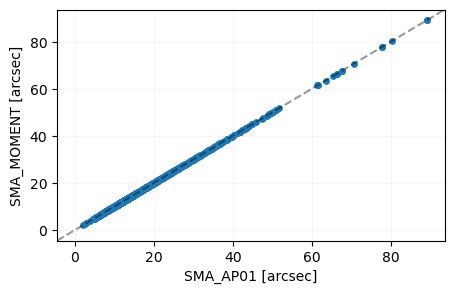

In [396]:
sma_ap1 = ellipse_tab['SMA_AP01']
sma_moment = ellipse_tab['SMA_MOMENT']

plt.figure(figsize=(5,3))
plt.scatter(sma_ap1, sma_moment,s=15)
plt.axline([0,0], slope=1, ls='--', color='black', alpha=0.4)
plt.xlabel('SMA_AP01 [arcsec]')
plt.ylabel('SMA_MOMENT [arcsec]')
plt.grid(alpha=0.1)
plt.show()

VAR check is complete. No penalty.

### QA Seven
#### MTOT vs. FLUX_AP04 fluxes
 - color-code by $\chi^2$ of wavelength band's COG

In [397]:
bands=['FUV','NUV','G','R','I','Z','W1','W2','W3','W4']   #uppercase GRIZ for FLUX_AP04_ and COG_MTOT_

ap04s = [f'FLUX_AP04_{band}' for band in bands]
mtots = [f'COG_MTOT_{band}' for band in bands]

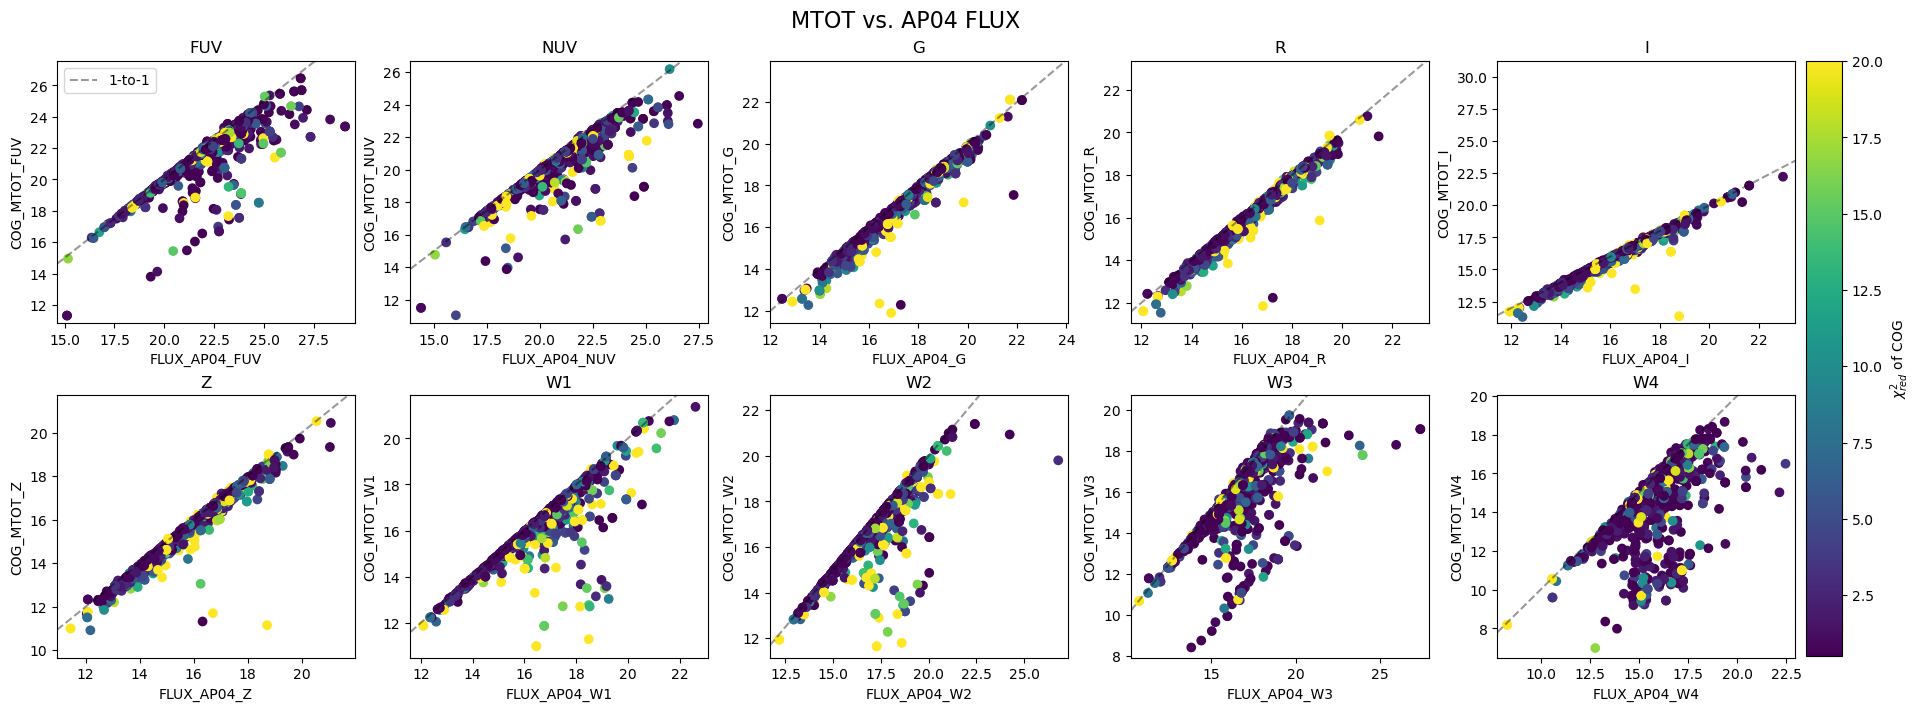

In [431]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    ap04 = ap04s[i-1]
    mtot = mtots[i-1]
    
    err_flag = (ellipse_tab[mtot]!=0)
    
    ap04_mag = 22.5 - 2.5*np.log10(ellipse_tab[ap04])
    mtot_mag = ellipse_tab[mtot]
    
    chi_red = ellipse_tab[f'COG_CHI2_{band}']/ellipse_tab[f'COG_NDOF_{band}']
    
    ax.set_title(bands[i-1])
    ax.set_xlabel(ap04)
    ax.set_ylabel(mtot)
    
    im=ax.scatter(ap04_mag[err_flag], mtot_mag[err_flag],
              c=chi_red[err_flag], vmin=0.5, vmax=20)
    ax.axline([0,0],slope=1,color='black',alpha=0.4,ls='--',label='1-to-1')
    
    ax.set_xlim(np.min(ap04_mag[err_flag&(~np.isnan(ap04_mag))])-0.5, 
                np.max(ap04_mag[err_flag&(~np.isnan(ap04_mag))])+0.5)
    
    ax.set_ylim(np.min(mtot_mag[err_flag&(~np.isnan(mtot_mag))])-0.5, 
                np.max(mtot_mag[err_flag&(~np.isnan(mtot_mag))])+0.5)
    
    if i==1:
        ax.legend(loc='upper left')

#relative x coord, relative y coord, relative thickness/width, relative length
cbar_ax = fig.add_axes([1, 0.07, 0.02, 0.85]) 
cbar=fig.colorbar(im, cax=cbar_ax, label=r'$\chi^2_{red}$ of COG')

fig.suptitle(r'MTOT vs. AP04 FLUX',fontsize=16)

plt.show()

### QA Eight
#### Colors with MTOT vs. colors with all AP apertures
- Want to check whether aperture choice biases color
- NOTE: convert g-r color to magnitudes using [g-r] = -2.5*log$_{10}\Big(\frac{flux_g}{flux_r}\Big)$
     - calculating the fraction directly eliminates the need for zeropoints. :-)

In [27]:
#g-r (MTOT) vs. g-r (AP), and r-z (MTOT) vs. r-z (AP)?
#one panel per aperture -- AP00, AP01, AP02, AP03, AP04

In [433]:
apertures = ['00', '01', '02', '03', '04']

mtot_g = ellipse_tab['COG_MTOT_G']
mtot_r = ellipse_tab['COG_MTOT_R']
mtot_z = ellipse_tab['COG_MTOT_Z']

err_flag = (mtot_g!=0) & (mtot_r!=0) & (mtot_z!=0)

mtot_g_r = mtot_g[err_flag] - mtot_r[err_flag]
mtot_r_z = mtot_r[err_flag] - mtot_z[err_flag]

ValueError: x and y must be the same size

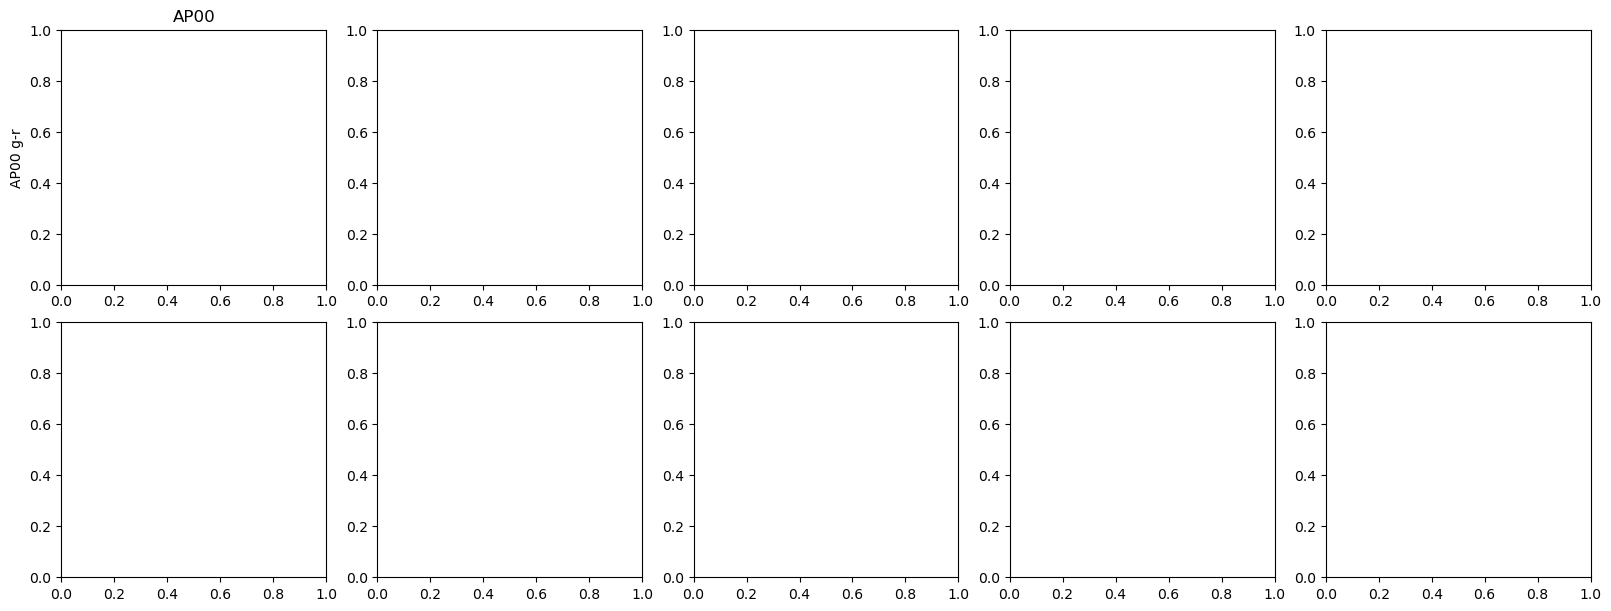

In [434]:
###############################
####         g-r           ####
###############################

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), constrained_layout=True)
axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    
    if i<6:
        ap_name=apertures[i-1]
    else:
        ap_name=apertures[i-6]
        
    ap_g = f'FLUX_AP{ap_name}_G'
    ap_r = f'FLUX_AP{ap_name}_R'
    g_r_ap = 2.5*-1*np.log10(ellipse_tab[ap_g]/ellipse_tab[ap_r])   #calculate color in magnitudes!

    if i<6:
        ax.set_title(f'AP{ap_name}')
        ax.set_ylabel(f'AP{ap_name} g-r')
        ax.scatter(mtot_g_r, g_r_ap, s=20)
        ax.axline([0,0], slope=1, color='black', alpha=0.4, ls='--')
        
        flag = (np.abs((mtot_g_r - g_r_ap)/mtot_g_r) > 0.2)
        sganames = ellipse_tab[flag]['SGAID']
        if np.sum(flag)>1:
            print(f'Galaxies with a relative difference in g-r method > 0.2 for AP{ap_name}: ')
            print(sganames.data)

    else:
        ax.set_ylabel(f'MTOT[g-r] - AP{ap_name}[g-r]')
        ax.set_xlabel('MTOT g-r',fontsize=14)
        ax.scatter(mtot_g_r, mtot_g_r - g_r_ap)
        ax.axhline(0, color='black', alpha=0.4, ls='--')
    
    ax.set_xlim(0.2,1)
        
fig.suptitle(r'FLUX_APxx vs. MTOT: g-r colors',fontsize=16)

###############################
####         r-z           ####
###############################

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), constrained_layout=True)
axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    
    if i<6:
        ap_name=apertures[i-1]
    else:
        ap_name=apertures[i-6]
        
    ap_r = f'FLUX_AP{ap_name}_R'
    ap_z = f'FLUX_AP{ap_name}_Z'
    r_z_ap = 2.5*-1*np.log10(ellipse_tab[ap_r]/ellipse_tab[ap_z])   #calculate color in magnitudes!

    if i<6:
        ax.set_title(f'AP{ap_name}')
        ax.set_ylabel(f'AP{ap_name} r-z')
        ax.scatter(mtot_r_z, r_z_ap, s=20,color='crimson')
        ax.axline([0,0], slope=1, color='black', alpha=0.4, ls='--')
        ax.set_xlim(0.2,1)

    else:
        ax.set_ylabel(f'MTOT[r-z] - AP{ap_name}[r-z]')
        ax.set_xlabel('MTOT r-z',fontsize=14)
        ax.scatter(mtot_r_z, mtot_r_z - r_z_ap, color='crimson')
        ax.axhline(0, color='black', alpha=0.4, ls='--')
        
        flag = (np.abs((mtot_r_z - r_z_ap)/mtot_r_z) > 0.2)
        sganames = ellipse_tab[flag]['SGAID']
        if np.sum(flag)>1:
            print(f'Galaxies with a relative difference in r-z method > 0.2 for AP{ap_name}: ')
            print(sganames.data)
        
    ax.set_xlim(0.2,1)
    
fig.suptitle(r'FLUX_APxx vs. MTOT: r-z colors',fontsize=16)

###############################
####                       ####
###############################

plt.show()

### QA Nine
#### Plot SMA_MOMENT vs.  R[isophote]_R
 - how does SMA_MOMENT correlate with isophotal radii for r-band (R)?
 - R22, R23, R24, R25, R26

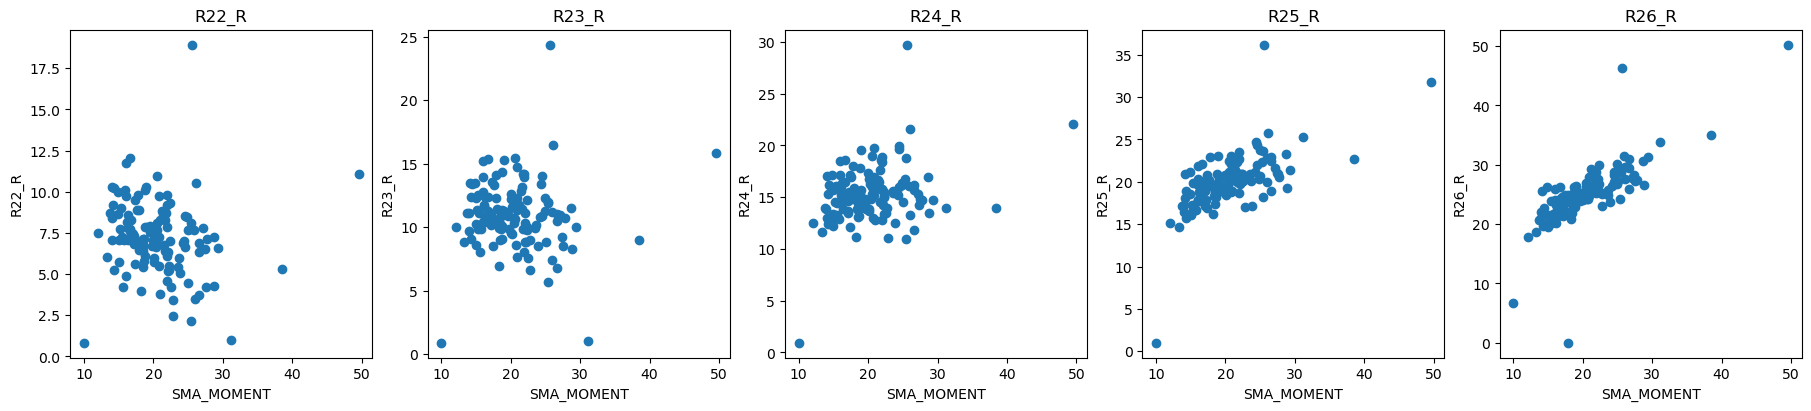

In [33]:
sma_moment = ellipse_tab['SMA_MOMENT'] #based on optical measurements

isophotes=['22','23','24','25','26']
r_isophotes = [f'R{isophote}_R' for isophote in isophotes]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    ax.set_title(f'R{isophotes[i-1]}_R')
    ax.set_xlabel('SMA_MOMENT')
    ax.set_ylabel(r_isophotes[i-1])
    im=ax.scatter(sma_moment, ellipse_tab[r_isophotes[i-1]])

#fig.suptitle(r'MTOT vs. AP04 FLUX (negative MTOT galaxies removed)',fontsize=16)

plt.show()